In [53]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e25/sample_submission.csv
/kaggle/input/playground-series-s3e25/train.csv
/kaggle/input/playground-series-s3e25/test.csv


In [54]:
train= pd.read_csv('/kaggle/input/playground-series-s3e25/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e25/test.csv')
train.head()

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
0,0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,6.0
1,1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,6.5
2,2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,2.5
3,3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,0.78937,6.0
4,4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,1.86481,6.0


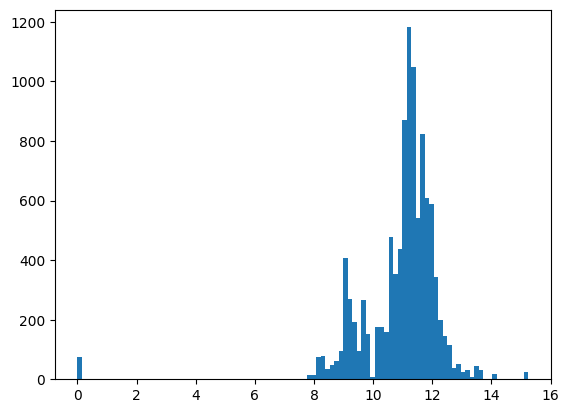

In [55]:
import matplotlib.pyplot as plt

plt.hist(train['ionenergy_Average'], bins=100)
plt.show()

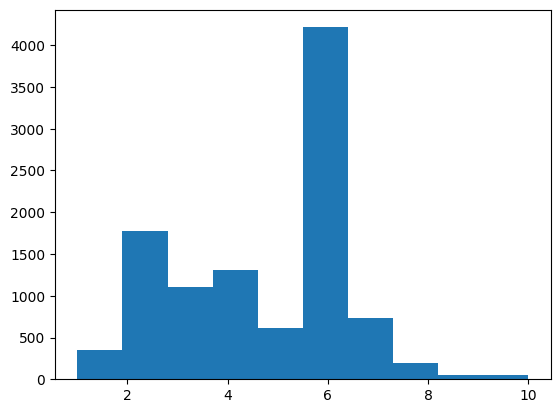

In [56]:
plt.hist(train['Hardness'],bins=10)
plt.show()

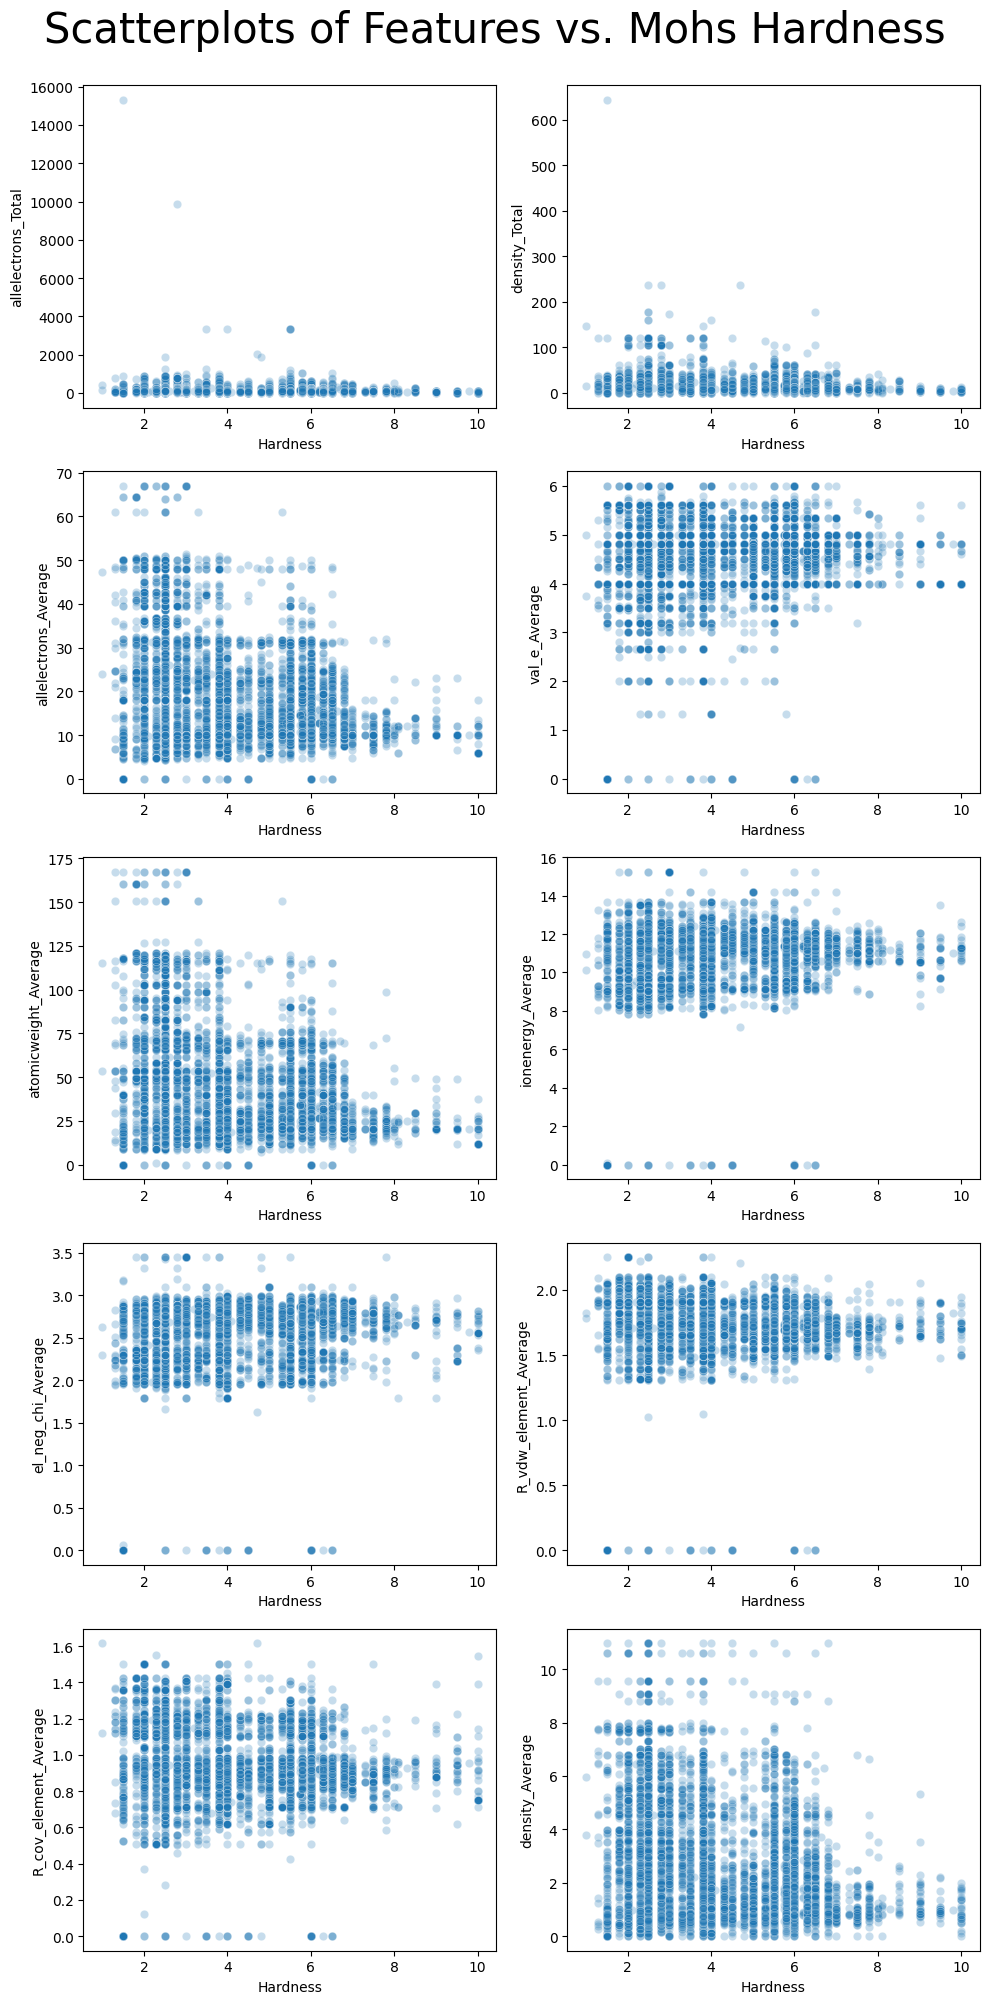

In [57]:
columns = ['allelectrons_Total', 'density_Total', 'allelectrons_Average', 'val_e_Average', 
           'atomicweight_Average', 'ionenergy_Average', 'el_neg_chi_Average', 
           'R_vdw_element_Average', 'R_cov_element_Average', 'density_Average']


fig, axs = plt.subplots(len(columns)//2, 2, figsize=(10, 20))

for i, column in enumerate(columns):
    row = i // 2
    col = i % 2
    sns.scatterplot(data=train, x='Hardness', y=column, alpha=0.25, ax=axs[row, col])
plt.suptitle('Scatterplots of Features vs. Mohs Hardness', y=1.0, fontsize=30)
plt.tight_layout()
plt.show()

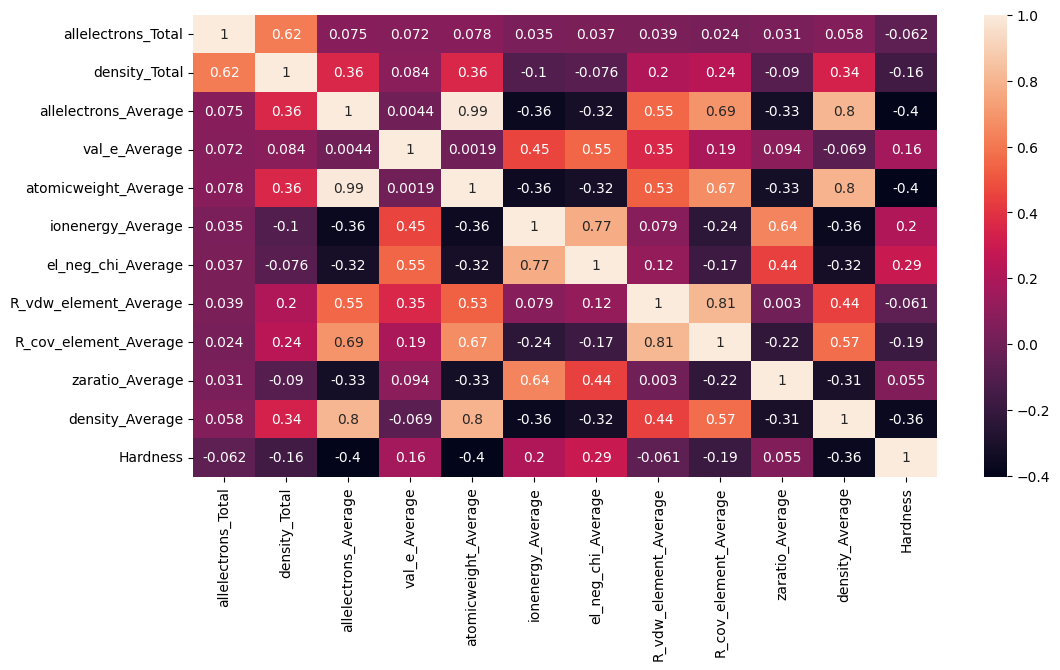

In [58]:

plt.figure(figsize=(12,6))
corr= train.drop(columns=['id']).corr()
sns.heatmap(corr,annot=True)
plt.show()

<Axes: xlabel='allelectrons_Average', ylabel='density_Average'>

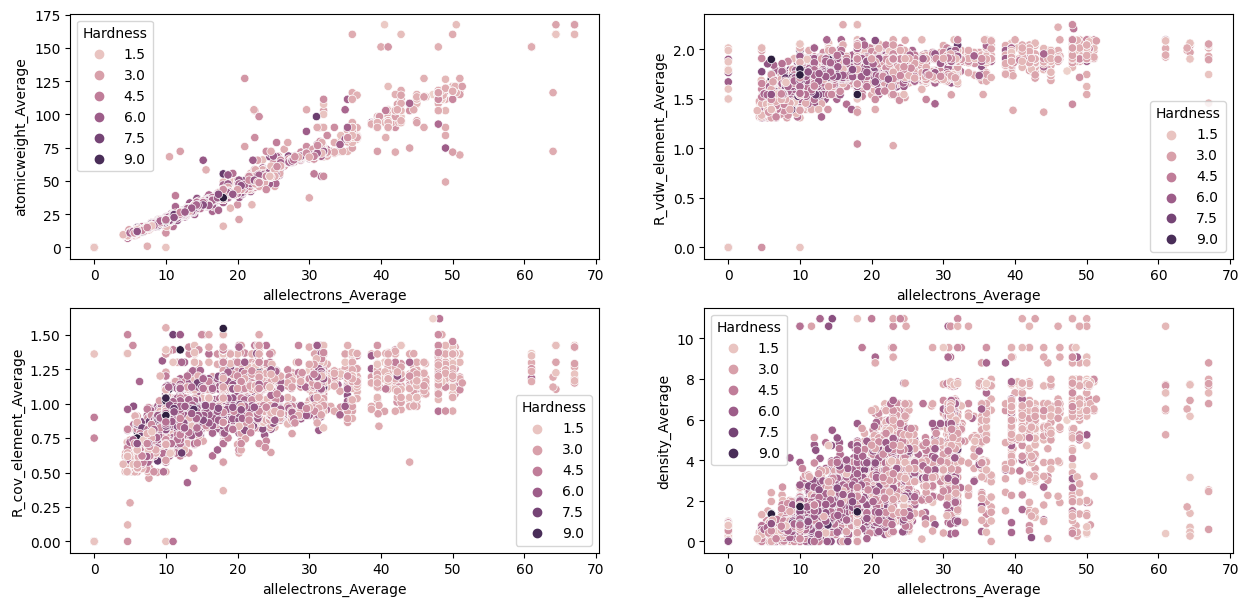

In [59]:
plt.figure(figsize=(15, 7))
plt.subplot(221)
sns.scatterplot(data=train, x='allelectrons_Average', y='atomicweight_Average', hue='Hardness')
plt.subplot(222)
sns.scatterplot(data=train, x='allelectrons_Average', y='R_vdw_element_Average', hue='Hardness')
plt.subplot(223)
sns.scatterplot(data=train, x='allelectrons_Average', y='R_cov_element_Average', hue='Hardness')
plt.subplot(224)
sns.scatterplot(data=train, x='allelectrons_Average', y='density_Average', hue='Hardness')

Importing libraries

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score

Seeing if there are missing values

In [61]:
imputer = SimpleImputer(strategy='mean')
X = train.drop(['Hardness'], axis=1)
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

In [62]:
X.shape

(10407, 12)

Splitting the data

In [75]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit the scaler to your data
scaler.fit(X)

# Transform your data
X_scaled = scaler.transform(X)
X_scaled.shape

(10407, 12)

Scaling the features

In [76]:
from sklearn.preprocessing import StandardScaler
y = train.Hardness
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# Print the shapes of the new splits
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (8325, 12)
X_test shape: (2082, 12)
y_train shape: (8325,)
y_test shape: (2082,)


Building multiple simple models

RandomForestRegressor

In [65]:
# Initialize Random Forest model
rf_model = RandomForestRegressor(n_estimators=50, max_depth=10, min_samples_split= 5)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test set
rf_predictions = rf_model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, rf_predictions)
mae = mean_absolute_error(y_test, rf_predictions)
r2 = r2_score(y_test, rf_predictions)

# Perform k-fold cross-validation
rf_cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rf_rmse_scores = np.sqrt(-rf_cv_scores)

# Print the metrics
print("Random Forest Regression Cross-Validation RMSE Scores:", rf_rmse_scores)
print("Mean RMSE:", rf_rmse_scores.mean())


Random Forest Regression Cross-Validation RMSE Scores: [1.21530341 1.29316923 1.28719191 1.19943481 1.22950159]
Mean RMSE: 1.2449201911513796


LGBMRegressor

In [66]:
lgbm_model = LGBMRegressor(n_estimators=200, max_depth=50, learning_rate=  0.1)

# Fit the model to the training data
lgbm_model.fit(X_train, y_train)

# Make predictions on the test set
lgbm_predictions = lgbm_model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, lgbm_predictions)
mae = mean_absolute_error(y_test, lgbm_predictions)
r2 = r2_score(y_test, lgbm_predictions)

# Perform k-fold cross-validation
lgbm_cv_scores = cross_val_score(lgbm_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
lgbm_rmse_scores = np.sqrt(-lgbm_cv_scores)

# Print the metrics
print("LGBM Regression Cross-Validation RMSE Scores:", lgbm_rmse_scores)
print("Mean RMSE:", lgbm_rmse_scores.mean())

LGBM Regression Cross-Validation RMSE Scores: [1.21311367 1.27475632 1.27291854 1.18536716 1.23008678]
Mean RMSE: 1.235248491994764


Comparing model performance

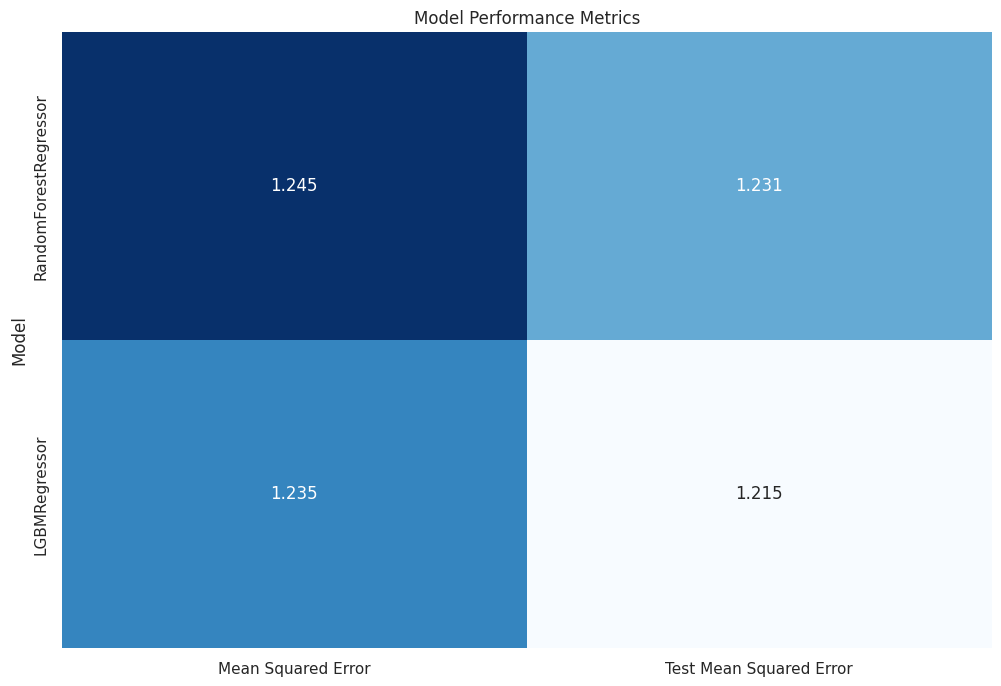

In [67]:
data = {
    'Model': ['RandomForestRegressor','LGBMRegressor'], 'Mean Squared Error':[rf_rmse_scores.mean(),lgbm_rmse_scores.mean()], 'Test Mean Squared Error':[np.sqrt(mean_squared_error(y_test, rf_predictions)), np.sqrt(mean_squared_error(y_test, lgbm_predictions))]}
df_metrics = pd.DataFrame(data)

# Plot a table using seaborn
plt.figure(figsize=(12,8))
sns.set_theme(style="whitegrid")
table = sns.heatmap(df_metrics.set_index('Model'), annot=True, cmap="Blues", fmt=".3f", cbar=False)
plt.title('Model Performance Metrics')
plt.show()

Will use LGBMRegressor for test predictions

In [68]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6939 entries, 0 to 6938
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     6939 non-null   int64  
 1   allelectrons_Total     6939 non-null   float64
 2   density_Total          6939 non-null   float64
 3   allelectrons_Average   6939 non-null   float64
 4   val_e_Average          6939 non-null   float64
 5   atomicweight_Average   6939 non-null   float64
 6   ionenergy_Average      6939 non-null   float64
 7   el_neg_chi_Average     6939 non-null   float64
 8   R_vdw_element_Average  6939 non-null   float64
 9   R_cov_element_Average  6939 non-null   float64
 10  zaratio_Average        6939 non-null   float64
 11  density_Average        6939 non-null   float64
dtypes: float64(11), int64(1)
memory usage: 650.7 KB


In [69]:
scaler = StandardScaler()

# Fit the scaler to your data
scaler.fit(test)

# Transform your data
test_scaled = scaler.transform(test)

In [70]:
test_scaled.shape
#test.head()

(6939, 12)

In [74]:
# Make predictions using the trained LGBM model
lgbm_predictions = lgbm_model.predict(test)

# lgbm_predictions` add the predictions to the test_df
test['Predicted_Hardness'] = lgbm_predictions

# Display the first few rows of the test_df with predictions
print(test[['id', 'Predicted_Hardness']].head())

ValueError: Number of features of the model must match the input. Model n_features_ is 12 and input n_features is 13

In [73]:
submission_df = pd.DataFrame({
    'id': test['id'],
    'Predicted_Hardness': Predicted_Hardness
})

# Save the DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)
submission_df

NameError: name 'Predicted_Hardness' is not defined

In [ ]:
sample_submission_df.to_csv('submission.csv', index=False)
